# Installations

In [ ]:
!pip3 install gurobipy
!pip3 install qiskit[visualization]
!pip3 install olsq
!pip3 install anytree

!pip3 install pytket
!pip3 install pytket-qiskit

In [ ]:
!git clone https://github.com/weiT1993/qiskit_helper_functions
!cp -r qiskit_helper_functions/* ./ && python3 setup.py install

In [ ]:
!git clone https://github.com/arnavdas88/CutQC
!cp -r CutQC/* ./ && python3 setup.py install

# Code

In [20]:
from qiskit.quantum_info import random_unitary
from qiskit.circuit.random import random_circuit
from qiskit_helper_functions.non_ibmq_functions import generate_circ
from qiskit_helper_functions.non_ibmq_functions import apply_measurement
from qiskit_helper_functions.conversions import dict_to_array

from cutqc.cutter import find_cuts
from cutqc.post_process import generate_summation_terms, get_naive_overhead # build
from cutqc.evaluator import run_subcircuit_instances
from cutqc.verify import verify

from anytree import Node, RenderTree
from anytree.exporter import DotExporter
from anytree.search import findall_by_attr

from pprint import pprint

from cutqc.cutter import subcircuits_parser, get_pairs, get_counter, cost_estimate
from cutqc.evaluator import modify_subcircuit_instance, mutate_measurement_basis, measure_prob

In [21]:
types = [
         # qiskit_helper_functions
         "bv",
         "supremacy",
         "supremacy_linear",
         "hwea",
         "qft",
         "aqft",
         "sycamore",
         "adder",
         "grover",
         "random",

         # qiskit.circuit.random
         "qiskit-random"
    ]

def generate_circuit(register_size = 12, depth=7, circuit_type = "bv"):

    if not circuit_type in types:
        raise Exception("Unknown circuit type.")

    if circuit_type == "qiskit-random":
        return random_circuit(register_size, depth, conditional=True, measure=False)

    return generate_circ(num_qubits=register_size, depth=depth, circuit_type=circuit_type)

def run_batch(definition, batch = 5, context = {}):
    return timeit.repeat(stmt="definition()", setup="", repeat=batch, number = batch, globals={ **globals(), **context, "definition": definition })


def avg(arr):
    return sum(arr) / len(arr)

In [22]:
def cut(circuit, verbose = True):

    sub_circuit_max = circuit.num_qubits

    # 6 is the max limit for `Gurobi` Optimier.
    if sub_circuit_max > 6:
        sub_circuit_max = 6

    circuit_const = int( circuit.size() / circuit.num_qubits )
    max_subcircuit_width = circuit.num_qubits + circuit_const
    max_subcircuit_cuts = circuit.num_qubits
    max_subcircuit_size = circuit.size() + circuit_const
    quantum_cost_weight = 1.0
    max_cuts = circuit.num_qubits - 2

    num_subcircuits = [s for s in range(2, sub_circuit_max)]

    kwargs = {
        "max_subcircuit_width": max_subcircuit_width,
        "max_subcircuit_cuts": max_subcircuit_cuts,
        "max_subcircuit_size": max_subcircuit_size,
        "quantum_cost_weight": quantum_cost_weight,
        "max_cuts": max_cuts,
        "num_subcircuits": num_subcircuits
    }
    
    return find_cuts(circuit=circuit, **kwargs, verbose=verbose)


def recursive_cut(circuit, callback=None, prefix='cut1', parent_node=None, min_qubit=None):
    if parent_node:
        node = Node(prefix, parent=parent_node)
    else:
        node = Node(prefix)

    cuts = cut(circuit, False)
    all_cuts = cuts.get('subcircuits', [])
    
    if len(all_cuts) < 2:
        if callback:
            callback(node, circuit, prefix)
        # print(f"Final Node : {prefix}")
        node.data = circuit
        return node
    else:
        node.data = circuit

        if min_qubit:
            if circuit.num_qubits <= min_qubit:
                if callback:
                    callback(node, circuit, prefix)
                return node

        node.complete_path_map = cuts.get('complete_path_map', {})
        node.cuts = cuts
        
        # if callback:
        #     callback(node, circuit, prefix)
        
        postfix = 0
        for circ in all_cuts:
            postfix = postfix + 1
            recursive_cut(circ, callback, prefix + str(postfix), node, min_qubit)
    
    return node

In [23]:
from pytket.routing import Architecture, route, place_with_map
from pytket.transform import Transform
from pytket.routing import Placement, LinePlacement, GraphPlacement, NoiseAwarePlacement
from pytket.extensions.qiskit import qiskit_to_tk, tk_to_qiskit

def Tket(circuit, backend = None, transform = False):
    pytket_circ = qiskit_to_tk(circuit)

    backend = get_backend_name(backend)
    backend = available_backend[backend]
    backend = backend()
    check_chip_compatiblity(backend, circuit) # Validate Chip Size to Circuit Size

    if transform:
        Transform.RemoveRedundancies().apply(physical_c)
        Transform.OptimisePostRouting().apply(physical_c)
        Transform.RebaseToQiskit().apply(physical_c)


    arc = Architecture(backend._configuration.coupling_map)

    # placement = Placement(arc)
    # placement_map = placement.get_placement_map(pytket_circ)

    physical_c = route(pytket_circ, arc)

    # placement.place(physical_c)
    # place_with_map(pytket_circ, placement_map)

    final_circ = tk_to_qiskit(physical_c)

    return final_circ

from qiskit.circuit import QuantumRegister, Qubit
from pprint import pprint
def tket_path(pathmap):
    map = pathmap.copy()
    q_node = Qubit(QuantumRegister(6, 'q'), 0)
    q_node.register.size, q_node.index
    
    for key, values in map.items():
        for index, conn in enumerate(map[key]): 
            # {'subcircuit_idx': 0, 'subcircuit_qubit': Qubit(QuantumRegister(4, 'q'), 0)}
            qubit = conn['subcircuit_qubit']
            qubit = Qubit(QuantumRegister(qubit.register.size, 'node'), qubit.index)
            qubit._hash = pathmap[key][index]['subcircuit_qubit']._hash
            map[key][index]['subcircuit_qubit'] = qubit
    return map

from qiskit import QuantumCircuit, QuantumRegister
def tket_rename_nodes(circuit):
    qreg = QuantumRegister(circuit.num_qubits , 'q')
    if circuit.cregs:
        creg = QuantumRegister(len(circuit.cregs) , 'c')
        circ = QuantumCircuit(qreg, creg)
    else:
        circ = QuantumCircuit(qreg)

    for instr, qargs, cargs in circuit._data:
        qreg = [ reg.index for reg in qargs ]
        circ.append(instr, qreg)

    return circ

In [24]:
def get_target_from_path(n, graph):

    key = [ k for k in filter ( lambda obj: obj.index == n, list(graph.keys()) )]

    return key, graph[key]

def get_mapped_from_path(subcircuit_idx, n, graph):

    def check(obj):
        for o in obj:
            if ( o['subcircuit_idx'] == subcircuit_idx ) and ( o['subcircuit_qubit'].index == n ):
                return True
        return False

    key = [ k for k in filter ( lambda obj: check(graph[obj]), list(graph.keys()) )]
    key = key[0]

    return key, graph[key]

def graph_output_circuit_nums(graph):
    size = []
    for val in graph.values():
        for v in val:
            size += [ v['subcircuit_idx'] ]
    return len(set(size))

def graph_output_circuit_ids(graph):
    size = []
    for val in graph.values():
        for v in val:
            size += [ v['subcircuit_idx'] ]
    return list(set(size))

def graph_input_circuit_size(graph):
    return list(graph.keys())[0].register.size

def get_cut_from_graph(graph):
    return [ mappings for mappings in list(graph.values()) if len(mappings) > 1][0]


def get_cut_idx(cut, graph):
    for channel in cut:
        if channel['subcircuit_qubit'] in graph:
            return channel['subcircuit_idx']
    return False


def clean_name_tree(node):
    if node.is_leaf:
        node.name = "node" + node.name[3:]
    [ clean_name_tree(child) for child in node.children ]
    return node

def get_solution(circuit, subcircuits, complete_path_map):

    # subcircuits, complete_path_map = subcircuits_parser(subcircuit_gates=subcircuits, circuit=circuit)
    O_rho_pairs = get_pairs(complete_path_map=complete_path_map)
    counter = get_counter(subcircuits=subcircuits, O_rho_pairs=O_rho_pairs)
    quantum_cost, classical_cost = cost_estimate(counter=counter)
    max_subcircuit_width = max([subcircuit.width() for subcircuit in subcircuits])

    cut_solution = {
        'max_subcircuit_width':max_subcircuit_width,
        'subcircuits':subcircuits,
        'complete_path_map':complete_path_map,
        'num_cuts':len(O_rho_pairs),
        'counter':counter,
        'classical_cost':classical_cost,
        'quantum_cost':quantum_cost}

    return cut_solution

def get_complete_path_map(pnode): # node_stack, circuit_stack, circuit):
    # 1.) get pnode->path_map
    # 2.) get (!pnode->is_leaf)=>(return pnode->path_map + pnode.children->get_complete_path_map without None)
    # 3.) 
    # 4.) (pnode->is_leaf)=>return none
    # complete_path_map

    if not pnode.is_leaf:
        child_path_map = [ get_complete_path_map(child) for child in pnode.children ]
        child_path_map = [ (child) for child in child_path_map if child ]
        if child_path_map:

            if len(child_path_map) == 1:
                child_path_map = child_path_map[0]
                return combine_path_map(pnode.complete_path_map, child_path_map)
            else:
                map = combine_path_map(pnode.complete_path_map, child_path_map[0])
                for i in range(1, len(child_path_map)):
                    map = combine_path_map(pnode.complete_path_map, child_path_map[i])
                child_path_map = map
                return child_path_map
        else:
            return pnode.complete_path_map
    else:
        return None


def combine_path_map(parent_path_map, child_path_map):

    result = parent_path_map

    reconstructed_map = {}

    parent_size = graph_output_circuit_nums(parent_path_map)
    child_size = graph_output_circuit_nums(child_path_map)
    total_size = parent_size + child_size

    circuit_piece = [ i for i in range(total_size + 1) ]

    parent_input_size = graph_input_circuit_size(parent_path_map)
    child_input_size  = graph_input_circuit_size(child_path_map)

    parent_piece_mapping = {}
    child_piece_mapping = {}

    cut = get_cut_from_graph(parent_path_map)
    cut_point = get_cut_idx(cut, list(child_path_map.keys()))
    end_point = child_size 

    parent_piece_mapping.update({ f:f for f in range(0, cut_point) })
    child_piece_mapping.update({ (f-cut_point):f for f in range(cut_point, end_point + cut_point) })
    parent_piece_mapping.update({(f-end_point + 1):f for f in range(end_point + cut_point, total_size - 1) })

    child_path_map_remapped = {}
    for key, values in child_path_map.items():
        remapped_values = []
        for piece in values:
            remapped_values += [{ 'subcircuit_idx': child_piece_mapping[ piece['subcircuit_idx'] ], 'subcircuit_qubit': piece['subcircuit_qubit'] }]
        child_path_map_remapped[key] = remapped_values

    parent_path_map_remapped = parent_path_map

    reconstructed_map = {}
    for qubit, qubit_to_sub_circuit_map in parent_path_map_remapped.items():
        map = qubit_to_sub_circuit_map
        join = []
        remove = []
        for index, connection in enumerate(qubit_to_sub_circuit_map):
            if connection['subcircuit_qubit'] in list( child_path_map_remapped.keys() ) and cut_point == connection['subcircuit_idx']:
                add_this = child_path_map_remapped[ connection['subcircuit_qubit'] ]
                join += add_this
            else:
                add_this = connection
                add_this['subcircuit_idx'] = parent_piece_mapping[add_this['subcircuit_idx']]
                join += [ add_this ]
            remove += [connection]

        [ map.remove(con) for con in remove ]

        map += join
        reconstructed_map[qubit] =  map
    
    new_output_map = { value: key for (key, value) in enumerate(graph_output_circuit_ids(reconstructed_map)) }
    reconstructed_map_correction = {}
    for key, values in reconstructed_map.items():
        remapped_values = []
        for piece in values:
            remapped_values += [{ 'subcircuit_idx': new_output_map[ piece['subcircuit_idx'] ], 'subcircuit_qubit': piece['subcircuit_qubit'] }]
        reconstructed_map_correction[key] = remapped_values


    return reconstructed_map_correction


In [25]:
from time import time
import itertools, copy

import numpy as np

from qiskit import IBMQ, transpile, Aer, execute

from qiskit.providers.aer import noise
from qiskit import QuantumCircuit
from qiskit.providers.aer import AerSimulator
from qiskit.tools.visualization import plot_histogram
from qiskit.test.mock import FakeBackend, FakeTokyo, FakeVigo, FakeMelbourne, FakePoughkeepsie, FakeQasmSimulator, FakeRueschlikon, FakeTenerife

available_backend = {
    "FakeTokyo": FakeTokyo, 
    "FakeVigo": FakeVigo, 
    "FakeMelbourne": FakeMelbourne, 
    "FakePoughkeepsie": FakePoughkeepsie, 
    "FakeRueschlikon": FakeRueschlikon, 
    "FakeTenerife": FakeTenerife
}

def get_alloted_backend(backend_stack, circ):
    for device, circuits in backend_stack.items():
        if circ in circuits:
            return device
    from pprint import pprint
    pprint(backend_stack)
    print("\n\n")
    print(type(circ))
    print([ circ ])
    raise Exception(f"The circuit {[circ]} has not been alocated to any device")

def get_backend_name(backend):
    for name, device in available_backend.items():
        if device is backend:
            return name
        if backend == name:
            return name
    raise Exception(f"Backend Error: No specified backend {str(backend)} found.")

def evaluate_circ(circuit, backend, options=None, TKET = False):
    
    if "tket_" in str(backend):
        backend_name = get_backend_name(backend[5:])
        TKET = True
    else:
        backend_name = get_backend_name(backend)
    # print("BACKEND : ", backend_name)
    if backend_name in available_backend:
        backend = available_backend[backend_name]()
        noise_model = noise.NoiseModel.from_backend(backend)
        if isinstance(options,dict) and 'num_shots' in options:
            num_shots = options['num_shots']
        else:
            num_shots = max(1024,2**circuit.num_qubits)
        if isinstance(options,dict) and 'memory' in options:
            memory = options['memory']
        else:
            memory = False
        if circuit.num_clbits == 0:
            circuit = apply_measurement(circuit=circuit,qubits=circuit.qubits)
            if TKET:
                circuit = Tket(circuit, backend_name)
            job = execute(circuit, backend=backend, noise_model=noise_model, shots=num_shots, memory=memory).result()
        if memory:
            qasm_memory = np.array(job.get_memory(0))
            assert len(qasm_memory)==num_shots
            return qasm_memory
        else:
            counts = job.get_counts(0)
            assert sum(counts.values())==num_shots
            counts = dict_to_array(distribution_dict=counts,force_prob=True)
            return counts
    if type(backend) is str:
        if backend=='statevector_simulator':
            backend = Aer.get_backend('statevector_simulator')
            job = execute(circuit, backend=backend, optimization_level=0)
            result = job.result()
            output_sv = result.get_statevector(circuit)
            output_p = []
            for x in output_sv:
                amplitude = np.absolute(x)**2
                if amplitude>1e-16:
                    output_p.append(amplitude)
                else:
                    output_p.append(0)
            output_p = np.array(output_p)
            return output_p
        elif backend == 'noiseless_qasm_simulator':
            if isinstance(options,dict) and 'num_shots' in options:
                num_shots = options['num_shots']
            else:
                num_shots = max(1024,2**circuit.num_qubits)
            backend = Aer.get_backend('qasm_simulator')

            if isinstance(options,dict) and 'memory' in options:
                memory = options['memory']
            else:
                memory = False
            if circuit.num_clbits == 0:
                circuit = apply_measurement(circuit=circuit,qubits=circuit.qubits)
            noiseless_qasm_result = execute(circuit, backend, shots=num_shots, memory=memory).result()

            if memory:
                qasm_memory = np.array(noiseless_qasm_result.get_memory(0))
                assert len(qasm_memory)==num_shots
                return qasm_memory
            else:
                noiseless_counts = noiseless_qasm_result.get_counts(0)
                assert sum(noiseless_counts.values())==num_shots
                noiseless_counts = dict_to_array(distribution_dict=noiseless_counts,force_prob=True)
                return noiseless_counts
        elif backend=='noisy_qasm_simulator':
            noisy_qasm_result = execute(circuit, Aer.get_backend('qasm_simulator'),
            coupling_map=options['coupling_map'],
            basis_gates=options['basis_gates'],
            noise_model=options['noise_model'],
            shots=options['num_shots']).result()

            noisy_counts = noisy_qasm_result.get_counts(0)
            assert sum(noisy_counts.values())==options['num_shots']
            noisy_counts = dict_to_array(distribution_dict=noisy_counts,force_prob=True)
            return noisy_counts
        else:
            raise NotImplementedError

def simulate_subcircuit(subcircuit,eval_mode,num_shots, tket=False):
    '''
    Simulate a subcircuit
    '''
    if eval_mode=='sv':
        subcircuit_inst_prob = evaluate_circ(circuit=subcircuit,backend='statevector_simulator')
    elif eval_mode=='qasm':
        subcircuit_inst_prob = evaluate_circ(circuit=subcircuit,backend='noiseless_qasm_simulator',options={'num_shots':num_shots})
    else:
        subcircuit_inst_prob = evaluate_circ(circuit=subcircuit,backend=eval_mode,options={'num_shots':num_shots}, TKET=tket)
    return subcircuit_inst_prob

def naive_compute(subcircuit_order, summation_terms, subcircuit_entry_probs):
	try:
		import cupy as cp
		CUDA = True
	except:
		import numpy as np
		CUDA = False
	reconstructed_prob = None
	for idx in range(len(summation_terms)):
		summation_term = summation_terms[idx]
		summation_term_prob = None
		for subcircuit_idx in subcircuit_order:
			subcircuit_entry_idx = summation_term[subcircuit_idx]
			subcircuit_entry_prob = subcircuit_entry_probs[subcircuit_idx][subcircuit_entry_idx]
			if summation_term_prob is None:
				summation_term_prob = subcircuit_entry_prob
			else:
				if CUDA:
					summation_term_prob = cp.array(summation_term_prob)
					subcircuit_entry_prob = cp.array(subcircuit_entry_prob)
					summation_term_prob = cp.kron(summation_term_prob,subcircuit_entry_prob)
					summation_term_prob = cp.asnumpy(summation_term_prob)
				else:
					summation_term_prob = np.kron(summation_term_prob,subcircuit_entry_prob)
                    
		if reconstructed_prob is None:
			reconstructed_prob = summation_term_prob
		else:
			reconstructed_prob += summation_term_prob
	return reconstructed_prob

def build(summation_terms, subcircuit_entry_probs, num_cuts, counter, verbose):
	min_overhead = float('inf')
	for subcircuit_order in itertools.permutations(range(len(subcircuit_entry_probs))):
		overhead = get_naive_overhead(subcircuit_order=subcircuit_order,num_cuts=num_cuts,counter=counter)
		if overhead['additions']+overhead['multiplications']<min_overhead:
			smart_order = subcircuit_order
			min_overhead = overhead['additions']+overhead['multiplications']
			if verbose:
				print('subcircuit_order {}. overhead = {}.'.format(subcircuit_order,overhead))
	
	reconstructed_prob = naive_compute(subcircuit_order, summation_terms, subcircuit_entry_probs)
	reconstructed_prob /= 2**num_cuts
	return reconstructed_prob, smart_order

def run_subcircuit_instances(subcircuits,subcircuit_instances,eval_mode,num_shots_fn, tket=False):
    '''
    subcircuit_instance_probs[subcircuit_idx][subcircuit_instance_idx] = measured probability
    '''
    subcircuit_instance_probs = {}
    for subcircuit_idx in subcircuit_instances:
        subcircuit_instance_probs[subcircuit_idx] = {}
        num_shots = num_shots_fn(subcircuits[subcircuit_idx])
        for init_meas in subcircuit_instances[subcircuit_idx]:
            subcircuit_instance_idx = subcircuit_instances[subcircuit_idx][init_meas]
            if subcircuit_instance_idx not in subcircuit_instance_probs[subcircuit_idx]:
                # print('Subcircuit %d instance %d'%(subcircuit_idx,subcircuit_instance_idx))
                subcircuit_instance = modify_subcircuit_instance(
                    subcircuit=subcircuits[subcircuit_idx],
                    init=init_meas[0],meas=init_meas[1])
                if  type(eval_mode) is dict:
                    # print("FOUND DICT", get_alloted_backend(eval_mode, subcircuits[subcircuit_idx]))
                    subcircuit_inst_prob = simulate_subcircuit(subcircuit=subcircuit_instance,eval_mode=get_alloted_backend(eval_mode, subcircuits[subcircuit_idx]),num_shots=num_shots, tket=tket)
                else:
                    # print("FOUND STR", get_alloted_backend(eval_mode, subcircuit_instance))
                    subcircuit_inst_prob = simulate_subcircuit(subcircuit=subcircuit_instance,eval_mode=eval_mode,num_shots=num_shots)
                mutated_meas = mutate_measurement_basis(meas=init_meas[1])
                for meas in mutated_meas:
                    measured_prob = measure_prob(unmeasured_prob=subcircuit_inst_prob,meas=meas)
                    mutated_subcircuit_instance_idx = subcircuit_instances[subcircuit_idx][(init_meas[0],meas)]
                    subcircuit_instance_probs[subcircuit_idx][mutated_subcircuit_instance_idx] = measured_prob
                    # print('Measured instance %d'%mutated_subcircuit_instance_idx)
    return subcircuit_instance_probs

def summation(subcircuits, complete_path_map, num_cuts, full_circuit):
    return generate_summation_terms(subcircuits, complete_path_map, num_cuts)

def _attribute_shots(summation_terms, subcircuit_entries, subcircuit_instances, subcircuits, backend=None, tket=False):
    '''
    eval_mode = qasm: simulate shots
    eval_mode = sv: statevector simulation
    num_shots_fn: a function that gives the number of shots to take for a given circuit
    '''
    eval_mode = 'sv'
    if backend:
        eval_mode = backend
    def constant_shots_fn(circuit):
        return 1024
    num_shots_fn = constant_shots_fn
    print("subcircuits : ", [ circ.num_qubits for circ in subcircuits ])
    print("subcircuit_instances : ", subcircuit_instances)
    subcircuit_instance_probs =run_subcircuit_instances(subcircuits=subcircuits,subcircuit_instances=subcircuit_instances, eval_mode=eval_mode,num_shots_fn=num_shots_fn, tket=tket)
    print("subcircuit_instance_probs : ", [ f"{key}: {len(proba)}    " for key, proba in subcircuit_instance_probs.items() ])

    subcircuit_entry_probs = {}
    for subcircuit_idx in subcircuit_entries:
        subcircuit_entry_probs[subcircuit_idx] = {}
        for label in subcircuit_entries[subcircuit_idx]:
            subcircuit_entry_idx, kronecker_term = subcircuit_entries[subcircuit_idx][label]
            # print('Subcircuit {:d} entry {:d} kronecker_term {}'.format(
            #     subcircuit_idx, subcircuit_entry_idx, kronecker_term
            # ))
            subcircuit_entry_prob = None
            for term in kronecker_term:
                coefficient, subcircuit_instance_idx = term
                if subcircuit_entry_prob is None:
                    subcircuit_entry_prob = coefficient * subcircuit_instance_probs[subcircuit_idx][subcircuit_instance_idx]
                else:
                    subcircuit_entry_prob += coefficient * subcircuit_instance_probs[subcircuit_idx][subcircuit_instance_idx]
            subcircuit_entry_probs[subcircuit_idx][subcircuit_entry_idx] = subcircuit_entry_prob
    return subcircuit_entry_probs

def reconstruct(subcircuits, complete_path_map, full_circuit, backend = None, tket=False):

    num_cuts = graph_output_circuit_nums(complete_path_map) - 1

    summation_terms, subcircuit_entries, subcircuit_instances = generate_summation_terms(subcircuits, complete_path_map, num_cuts)

    cuts = get_solution(full_circuit, subcircuits, complete_path_map)

    subcircuit_entry_probs = _attribute_shots(summation_terms, subcircuit_entries, subcircuit_instances, subcircuits, backend=backend, tket=tket)

    reconstructed_prob, smart_order = build(summation_terms, subcircuit_entry_probs, num_cuts, cuts['counter'], True)

    unordered_prob = reconstructed_prob
    reconstructed_output, metrics = verify(full_circuit=full_circuit,
                unordered=unordered_prob,
                complete_path_map=cuts['complete_path_map'],
                subcircuits=subcircuits,
                smart_order=smart_order)
    return reconstructed_output, metrics


In [26]:
from qiskit import QuantumCircuit, execute

class CircuitLargerThanChip(Exception):
    pass

def check_chip_compatiblity(backend, circuit, raise_exception=True):
    if backend._configuration.n_qubits < circuit.num_qubits:
        if raise_exception:
            raise CircuitLargerThanChip("Circuit is larger than chip size.")
        else:
            return False
    return True


In [27]:
node_stack = {}
circuit_stack = {}
 
def callback(node, circuit, prefix):
    circuit_stack[prefix] = circuit
    node_stack[prefix] = node

circuit = generate_circuit( 12, "bv" )
pnode = recursive_cut(circuit, callback=callback, min_qubit=3)
clean_name_tree(pnode)

for pre, fill, node in RenderTree(pnode):
    print("%s%s" % (pre, node.name + " : " + str(node.data.num_qubits)))

complete_path_map = get_complete_path_map(pnode)
solution = get_solution(circuit, list(circuit_stack.values()), complete_path_map)

# pprint(solution)


subcircuits = list( circuit_stack.values() )
reconstructed_output, metrics = reconstruct(subcircuits, complete_path_map, circuit, backend="FakeTokyo")

pprint(metrics)
reconstructed_output, metrics = reconstruct(subcircuits, complete_path_map, circuit, backend="tket_FakeTokyo")

pprint(metrics)

Academic license - for non-commercial use only - expires 2021-09-24
Using license file C:\Users\turba\gurobi.lic
cut1 : 12
├── cut11 : 9
│   ├── cut111 : 6
│   │   ├── cut1111 : 4
│   │   │   ├── node11111 : 2
│   │   │   └── node11112 : 3
│   │   └── node1112 : 3
│   └── cut112 : 4
│       ├── node1121 : 2
│       └── node1122 : 3
└── cut12 : 4
    ├── node121 : 2
    └── node122 : 3
subcircuits :  [2, 3, 3, 2, 3, 2, 3]
subcircuit_instances :  {0: {(('zero', 'zero'), ('comp', 'I')): 0, (('zero', 'zero'), ('comp', 'X')): 1, (('zero', 'zero'), ('comp', 'Y')): 2, (('zero', 'zero'), ('comp', 'Z')): 3}, 1: {(('zero', 'zero', 'zero'), ('comp', 'comp', 'I')): 0, (('zero', 'zero', 'one'), ('comp', 'comp', 'I')): 1, (('zero', 'zero', 'plus'), ('comp', 'comp', 'I')): 2, (('zero', 'zero', 'plusI'), ('comp', 'comp', 'I')): 3, (('zero', 'zero', 'zero'), ('comp', 'comp', 'X')): 4, (('zero', 'zero', 'one'), ('comp', 'comp', 'X')): 5, (('zero', 'zero', 'plus'), ('comp', 'comp', 'X')): 6, (('zero', 'z

<ipython-input-24-6b15b730eb78>:35: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  return list(graph.keys())[0].register.size


subcircuit_instance_probs :  ['0: 4    ', '1: 16    ', '2: 16    ', '3: 16    ', '4: 16    ', '5: 16    ', '6: 4    ']
subcircuit_order (0, 1, 2, 3, 4, 5, 6). overhead = {'additions': 16773120, 'multiplications': 20348928}.
subcircuit_order (0, 1, 2, 3, 5, 4, 6). overhead = {'additions': 16773120, 'multiplications': 19824640}.
subcircuit_order (0, 1, 3, 2, 5, 4, 6). overhead = {'additions': 16773120, 'multiplications': 19759104}.
subcircuit_order (0, 1, 3, 5, 2, 4, 6). overhead = {'additions': 16773120, 'multiplications': 19628032}.
subcircuit_order (0, 3, 1, 5, 2, 4, 6). overhead = {'additions': 16773120, 'multiplications': 19611648}.
subcircuit_order (0, 3, 5, 1, 2, 4, 6). overhead = {'additions': 16773120, 'multiplications': 19578880}.
{'naive': {'Cross Entropy': 2.6517796073544266,
           'HOP': 0.07052559345201082,
           'Mean Absolute Percentage Error': 226922462536130.22,
           'Mean Squared Error': 0.00021215145513529967,
           'chi2': 1.7364823638654197},
 '

In [28]:
# print(Tket(circuit, FakeTokyo).draw())
# tket_rename_nodes(Tket(circuit, FakeTokyo)).draw()

In [29]:
{ name:device()._configuration.n_qubits for name, device in available_backend.items() }

{'FakeTokyo': 20,
 'FakeVigo': 5,
 'FakeMelbourne': 14,
 'FakePoughkeepsie': 20,
 'FakeRueschlikon': 16,
 'FakeTenerife': 5}

In [13]:
!git clone https://github.com/uuudown/QASMBench

Cloning into 'QASMBench'...


In [30]:
import os, qiskit

from qiskit.dagcircuit.dagcircuit import DAGCircuit
from qiskit.converters import circuit_to_dag, dag_to_circuit

def circuit_measure_stripping(circuit):
    # Remove all single qubit gates and barriers in the circuit
    dag = circuit_to_dag(circuit)
    stripped_dag = DAGCircuit()
    [stripped_dag.add_qreg(x) for x in circuit.qregs]
    for vertex in dag.topological_op_nodes():
        # if len(vertex.qargs) == 2 and vertex.op.name!='barrier':
        if vertex.op.name != "measure":
            stripped_dag.apply_operation_back(op=vertex.op, qargs=vertex.qargs)
    return dag_to_circuit(stripped_dag)

def load_qasm(root, qasm_files):
    result = {}
    for qasm_file in qasm_files:
        try:
            result [ qasm_file.replace(".qasm", "") ] = circuit_measure_stripping ( QuantumCircuit.from_qasm_file(f"{root}/{qasm_file}") )
        except qiskit.qasm.QasmError as ex:
            print(f"Cannot load qasm file {qasm_file} because of QASM Error...")
        except Exception as ex:
            print(f"Cannot load qasm file {qasm_file} because of Unknown Error...")
            # raise ex
    return result

def qasm_benchmark(base) -> dict:
    result = {}
    for (root,dirs,files) in os.walk(base):
        qasm_files = [ file for file in files if ".qasm" == file[-5:] ]
        if not qasm_files:
            circs = [ qasm_benchmark(directory).items() for directory in dirs ]
            result.update( dict( [circ for circ in circs if len(circ) == 2] ))
        else:
            result.update( load_qasm(root, qasm_files) )
            # print(qasm_files)
    return result


In [31]:
# benchmark_circuits = qasm_benchmark('QASMBench/small')

In [32]:
class Schedular:
    def __init__(self, backend_list):
        self.backend_list = backend_list
        self.backend_sizes = { backend()._configuration.n_qubits: backend for backend in backend_list }
        self.backend_run_stack = { backend: [] for backend in backend_list }
        self.pnode = None
        self.smallest_chip_size = min([device()._configuration.n_qubits for device in backend_list])
        self.node_stack = {}
        self.circuit_stack = {}
        
    def callback(self, node, circuit, prefix):
        self.circuit_stack[prefix] = circuit
        self.node_stack[prefix] = node

    def __call__(self, circuit, tket=False, save_results=True):
        try:
            self.pnode = recursive_cut(circuit, callback=self.callback, min_qubit=self.smallest_chip_size)
        except AssertionError as ex:
            return (None, None)
        [ self.alot(circuit) for circuit in list(self.circuit_stack.values()) ]

        # Distribute the circuit if some devices are free
        empty_devices = [backend for backend, run_stack in self.backend_run_stack.items() if len(run_stack) == 0]
        for devices in empty_devices:
            run_stack_size = [ len(run_stack) for backend, run_stack in self.backend_run_stack.items() ]
            most_busy = [ (backend, run_stack) for backend, run_stack in self.backend_run_stack.items() if len(run_stack) == max(run_stack_size) ]
            backend, run_stack = most_busy[0]
            size = len(run_stack)
            new_run_stack_1 = run_stack[:size//2]
            new_run_stack_2 = run_stack[size//2:]
            self.backend_run_stack[backend] = new_run_stack_1
            self.backend_run_stack[devices] = new_run_stack_2
        
        # for device, circuits in self.backend_run_stack.items():
        #     remapped_tket_circuits = []
        #     for circ in circuits:
        #         final_circ = Tket(circ, device)
        #         remapped_tket_circuits += [final_circ]
        #         result = execute(final_circ, device(), shots=1024)
        #         print(result.result())

        subcircuits = list( self.circuit_stack.values() )
        if len(subcircuits)  < 2:
            print(f"Total {len(subcircuits)} subcircuits found...")
            return (None , None)
        # print(f"Circuit Stack : {self.circuit_stack}")
        # print(f"Subscircuits : {subcircuits}")
        # print(f"Main Circuit : {[circuit]}")
        # print(self.backend_run_stack)
        complete_path_map = get_complete_path_map(self.pnode)

        solution = get_solution(circuit, subcircuits, complete_path_map)
        reconstructed_output, metrics = reconstruct(subcircuits, complete_path_map, circuit, self.backend_run_stack, tket=True)

        if save_results:
            if list(reconstructed_output) != None and metrics: 

                save_name = "tket " + name if tket else name
                save({"reconstructed_output": reconstructed_output, "metrics": metrics}, save_name)

        return (reconstructed_output, metrics) # self.backend_run_stack

    def alot(self, circuit):
        # Fill `backend_run_stack` in order from low to high
        size_list = list(self.backend_sizes.keys())
        size_list = list(sorted(list(size_list)))
        for size in size_list:
            backend = self.backend_sizes[size]
            if check_chip_compatiblity(backend(), circuit):
                self.backend_run_stack[backend] += [circuit]
                return backend
        raise Exception("Circuit too big for available devices.")

    def kernal(self, circuit):
        pass

In [33]:
backend_list

[qiskit.test.mock.backends.tokyo.fake_tokyo.FakeTokyo,
 qiskit.test.mock.backends.vigo.fake_vigo.FakeVigo,
 qiskit.test.mock.backends.melbourne.fake_melbourne.FakeMelbourne,
 qiskit.test.mock.backends.poughkeepsie.fake_poughkeepsie.FakePoughkeepsie,
 qiskit.test.mock.backends.rueschlikon.fake_rueschlikon.FakeRueschlikon,
 qiskit.test.mock.backends.tenerife.fake_tenerife.FakeTenerife]

In [ ]:
import pickle

def save(obj, filename):
    with open(f'{filename}.pickle', 'wb') as handle:
        pickle.dump(obj, handle, protocol=pickle.HIGHEST_PROTOCOL)

metrics_list = []

backend_list = list(available_backend.values())

print("Creating Circuit...")
circuit_list = {}
for circtype in [
         # qiskit_helper_functions
#          "bv",
#          "supremacy",
#          "supremacy_linear",
#          "hwea",
#          "qft",
#          "aqft",
#          "sycamore",
#          "adder",
         "grover"
#          "random",

         # qiskit.circuit.random
#          "qiskit-random"
    ]:
    for qubit in range(6, 12):
        for depth in range(10, 20):
            try:
                circuit_list.update( { f"cirucit [{circtype}-{depth}-{qubit}]": generate_circuit( qubit, circtype )  } )
            except:
                print(f"cirucit [{circtype}-{depth}-{qubit}] not possible")

print(circuit_list)
print("Circuits Loaded...")


schedule = Schedular(backend_list)

for name, circ in circuit_list.items():
    try:
        reconstructed_output, metrics = schedule(circ, False)
        if metrics:
            metrics_list += [ metrics ]

    except Exception as ex:
        print(f"Exception found for circuit {ex}...")
        pass    
    try:
        reconstructed_output, metrics = schedule(circ, True)
        if metrics:
            metrics_list += [ metrics ]
    except Exception as ex:
        print(f"Exception found for circuit {ex}...")
        pass
    

Creating Circuit...
{'cirucit [grover-10-6]': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x0000021F7EBD3400>, 'cirucit [grover-11-6]': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x0000021F7EBCED30>, 'cirucit [grover-12-6]': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x0000021F7EBCEFA0>, 'cirucit [grover-13-6]': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x0000021F7EBCEB20>, 'cirucit [grover-14-6]': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x0000021F3F2E9EE0>, 'cirucit [grover-15-6]': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x0000021F3F2E9160>, 'cirucit [grover-16-6]': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x0000021F3F2E9580>, 'cirucit [grover-17-6]': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x0000021F3F2184C0>, 'cirucit [grover-18-6]': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x0000021F3F218130>, 'cirucit [grover-19-6]': <qiskit.circuit.quantumcircuit.Quant

In [ ]:
metrics_list[0]

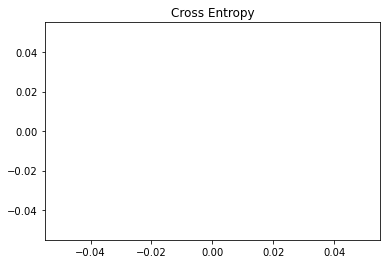

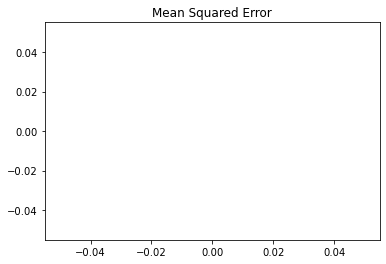

In [37]:
# importing the required libraries
import matplotlib.pyplot as plt
import numpy as np

def draw(line1, line2, title, start_from = 0):
    plt.plot([i for i in range(start_from, start_from+len(line1))], line1) # Plot the chart
    plt.plot([i for i in range(start_from, start_from+len(line2))], line2, '-.') # Plot the chart
    # plt.xlabel("X-axis data")
    # plt.ylabel("Y-axis data")
    plt.title(title)
    plt.show() # display

def plot_metric(metrics_list, column):
    hop_naive = [metric['naive'][column]  for metric in metrics_list]
    hop_nearest = [metric['nearest'][column]  for metric in metrics_list]

    draw(hop_naive, hop_nearest, column, 6)

plot_metric(metrics_list, 'Cross Entropy')
plot_metric(metrics_list, 'Mean Squared Error')

In [ ]:
# importing the required libraries
import matplotlib.pyplot as plt
import numpy as np

def draw(line1, line2, title, start_from = 0):
    plt.plot([i for i in range(start_from, start_from+len(line1))], line1) # Plot the chart
    plt.plot([i for i in range(start_from, start_from+len(line2))], line2, '-.') # Plot the chart
    # plt.xlabel("X-axis data")
    # plt.ylabel("Y-axis data")
    plt.title(title)
    plt.show() # display

def plot_metric(metrics_list, column):
    hop_naive = [metric['naive'][column]  for metric in metrics_list]
    hop_nearest = [metric['nearest'][column]  for metric in metrics_list]

    draw(hop_naive, hop_nearest, column, 6)

plot_metric(metrics_list, 'Cross Entropy')
plot_metric(metrics_list, 'Mean Squared Error')